# Natural Language Processing - Wikipedia API Integration

The three parts of this project are:
- Part 1: Use a traditional dataset in a CSV file
- Part 2: Use the Wikipedia API to directly access content on Wikipedia
- Part 3: Make your notebook interactive

# Part 1: Natural Language Processing with TextBlob and Text Representation

In [94]:
number = [5000]

## Setup and Imports

In [95]:
%%capture
%pip install -U textblob wikipedia beautifulsoup4
!python -m textblob.download_corpora

import time
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import wikipedia
from bs4 import BeautifulSoup
from textblob import TextBlob, Word, Blobber
from ipywidgets import widgets

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

## Load the CSV file

In [96]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv"
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())
print(df.shape)


                                                 URI                 name  \
0        <http://dbpedia.org/resource/Digby_Morrell>        Digby Morrell   
1       <http://dbpedia.org/resource/Alfred_J._Lewy>       Alfred J. Lewy   
2        <http://dbpedia.org/resource/Harpdog_Brown>        Harpdog Brown   
3  <http://dbpedia.org/resource/Franz_Rottensteiner>  Franz Rottensteiner   
4               <http://dbpedia.org/resource/G-Enka>               G-Enka   

                                                text  
0  digby morrell born 10 october 1979 is a former...  
1  alfred j lewy aka sandy lewy graduated from un...  
2  harpdog brown is a singer and harmonica player...  
3  franz rottensteiner born in waidmannsfeld lowe...  
4  henry krvits born 30 december 1974 in tallinn ...  
(42786, 3)


## Clean and preprocess the data

In [97]:
df['name'] = df['name'].str.lower()
df['name'] = df['name'].str.replace(r'[^\w\s]', '', regex=True)
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

## Create a TF-IDF vectorizer and transform the data

In [98]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

## Implement the K-Nearest Neighbors algorithm

In [99]:
nn = NearestNeighbors(n_neighbors=11, metric='cosine')
nn.fit(X)

NearestNeighbors(metric='cosine', n_neighbors=11)

## Create a function to find nearest neighbors and sentiment

In [100]:
def find_nearest_neighbors_and_sentiment(person_name):
    # Find the index of the person
    person_index = df[df['name'] == person_name].index[0]
    
    # Get the nearest neighbors
    distances, indices = nn.kneighbors(X[person_index].reshape(1, -1))
    
    # Get the names of the nearest neighbors (excluding the person itself)
    nearest_neighbors = df.iloc[indices[0][1:]]['name'].tolist()
    
    # Calculate sentiment for the person
    person_text = df.loc[person_index, 'text']
    sentiment = TextBlob(person_text).sentiment
    
    return nearest_neighbors, sentiment

## Get nearest nearest neighbors and sentiment

In [101]:
x = 5000

person_name = df['name'].iloc[x]  # choose a person 
nearest_neighbors, sentiment = find_nearest_neighbors_and_sentiment(person_name)

print(f"Nearest neighbors to {person_name}:")
for neighbor in nearest_neighbors:
    print(f"- {neighbor}")

print(f"\nSentiment of {person_name}'s text:")
print(f"Polarity: {sentiment.polarity}")
print(f"Subjectivity: {sentiment.subjectivity}")

Nearest neighbors to donne trotter:
- thomas l kilbride
- marvin e aspen
- kimberly a lightford
- john w darrah
- hiram monserrate
- james g carr
- jim waring
- samuel h young
- todd sieben
- thomas w ewing

Sentiment of donne trotter's text:
Polarity: 0.007688688123470734
Subjectivity: 0.31977225672877846


## Perform dimensionality reduction using TruncatedSVD

In [102]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)

# Part 2: Wikipedia API Integration

## Function to retrieve Wikipedia content

In [103]:
import wikipedia
from bs4 import BeautifulSoup
import time

def get_wikipedia_content(person_name):
    max_attempts = 5
    for attempt in range(max_attempts):
        try:
            page = wikipedia.page(person_name)
            return page.content
        except wikipedia.exceptions.DisambiguationError as e:
            options = e.options
            if not options:
                print(f"No suitable options found for {person_name}")
                return None
            
            # Try each option in order
            for option in options:
                try:
                    page = wikipedia.page(option)
                    return page.content
                except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError):
                    continue
            
            print(f"All disambiguation options exhausted for {person_name}")
            return None
        
        except wikipedia.exceptions.PageError:
            print(f"No Wikipedia page found for {person_name}")
            return None
        
        except Exception as e:
            print(f"An error occurred while fetching Wikipedia page for {person_name}: {str(e)}")
            time.sleep(1)  # Add a delay to avoid hitting API rate limits
    
    print(f"Max attempts reached for {person_name}")
    return None


## Function to clean text

In [104]:
def clean_text(text):
    text = text.lower()
    words = text.split()
    singularized_words = [Word(word).singularize() for word in words]
    return ' '.join(singularized_words)

## Function to analyze Wikipedia content

In [105]:
def analyze_wikipedia_content(person_name, nearest_neighbors):
    # Fetch Wikipedia content for the main person
    main_content = get_wikipedia_content(person_name)
    
    if main_content is None:
        print(f"No suitable Wikipedia page found for {person_name}")
        return None, None, None, None
    
    # Clean the main content
    main_content = clean_text(main_content)
    
    # Collect and clean Wikipedia pages from the nearest neighbors
    neighbor_contents = []
    unique_neighbors = set()
    for neighbor in nearest_neighbors:
        content = get_wikipedia_content(neighbor)
        if content is not None:
            cleaned_content = clean_text(content)
            if cleaned_content not in unique_neighbors:
                neighbor_contents.append(cleaned_content)
                unique_neighbors.add(cleaned_content)
        else:
            print(f"Skipping {neighbor} due to missing content")
    
    if len(neighbor_contents) < 2:
        print(f"Not enough data to perform analysis. Found {len(neighbor_contents)} out of {len(nearest_neighbors)} neighbors.")
        return None, None, None, None
    
    # Create Bag of Words and TF-IDF representations
    bow_vectorizer = CountVectorizer(stop_words='english')
    bow_matrix = bow_vectorizer.fit_transform([main_content] + neighbor_contents)

    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform([main_content] + neighbor_contents)

    # Calculate cosine similarity
    bow_similarity = cosine_similarity(bow_matrix[0].reshape(1, -1), bow_matrix[1:])
    tfidf_similarity = cosine_similarity(tfidf_matrix[0].reshape(1, -1), tfidf_matrix[1:])

    # Print debug information
    print("TF-IDF Matrix shape:", tfidf_matrix.shape)
    print("TF-IDF Similarity shape:", tfidf_similarity.shape)
    print("TF-IDF Similarity values:", tfidf_similarity)

    # Calculate rankings
    bow_ranking = np.argsort(bow_similarity[0])[::-1]
    tfidf_ranking = np.argsort(tfidf_similarity[0])[::-1]

    # Remove duplicates from rankings
    bow_unique = []
    tfidf_unique = []
    seen_names = set()

    for name in bow_ranking[1:]:  # Skip the first element (main person)
        if nearest_neighbors[name] not in seen_names:
            bow_unique.append(name)
            seen_names.add(nearest_neighbors[name])

    for name in tfidf_ranking[1:]:  # Skip the first element (main person)
        if nearest_neighbors[name] not in seen_names:
            tfidf_unique.append(name)
            seen_names.add(nearest_neighbors[name])

    # Calculate rankings
    bow_ranking = np.argsort(bow_similarity[0])[::-1]
    tfidf_ranking = np.argsort(tfidf_similarity[0])[::-1]

    # Create rankings based on similarity scores
    bow_wikipedia_ranking = [nearest_neighbors[i] for i in bow_ranking]
    tfidf_wikipedia_ranking = [nearest_neighbors[i] for i in tfidf_ranking]

    return main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix


## use the function to analyze Wikipedia content for a specific person and nearest neighbors

In [106]:
main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix = analyze_wikipedia_content(person_name, nearest_neighbors)

if main_content is not None:
    print(f"\nBoW Ranking:")
    for i, neighbor in enumerate(bow_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")

    print("\nTF-IDF Ranking:")
    for i, neighbor in enumerate(tfidf_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")
else:
    print("No suitable Wikipedia page found for the main person.")

/usr/local/lib/python3.12/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.12/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


TF-IDF Matrix shape: (11, 2151)
TF-IDF Similarity shape: (1, 10)
TF-IDF Similarity values: [[0.13061063 0.12520582 0.17780036 0.14956547 0.10533721 0.04664019
  0.14184413 0.05863536 0.15109683 0.04776455]]

BoW Ranking:
1. kimberly a lightford
2. todd sieben
3. john w darrah
4. thomas l kilbride
5. jim waring
6. marvin e aspen
7. hiram monserrate
8. samuel h young
9. thomas w ewing
10. james g carr

TF-IDF Ranking:
1. kimberly a lightford
2. todd sieben
3. john w darrah
4. jim waring
5. thomas l kilbride
6. marvin e aspen
7. hiram monserrate
8. samuel h young
9. thomas w ewing
10. james g carr


# # Visualization

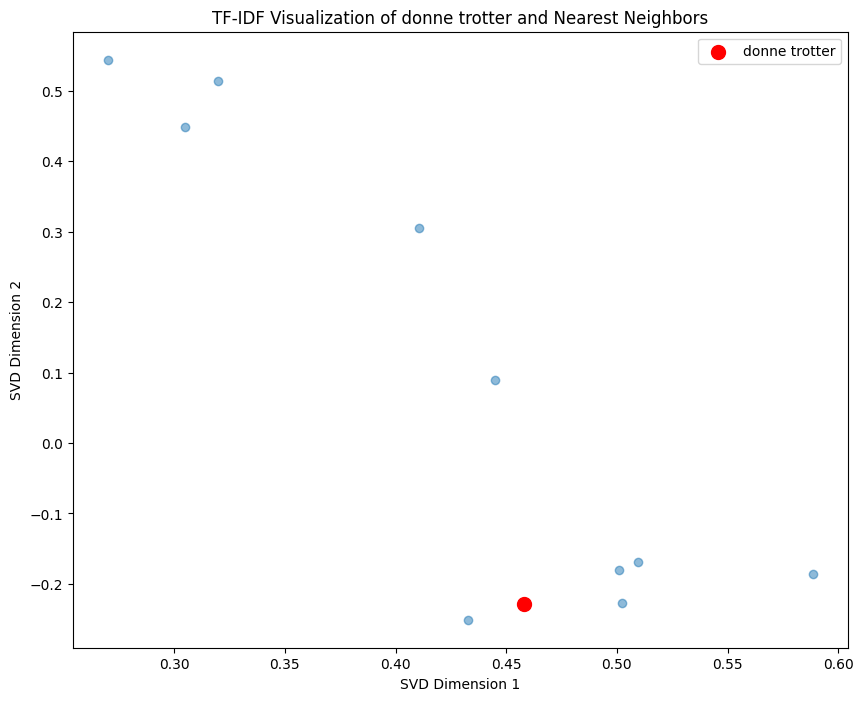

In [107]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(X_svd[1:, 0], X_svd[1:, 1], alpha=0.5)
plt.scatter(X_svd[0, 0], X_svd[0, 1], color='red', s=100, label=person_name)
plt.title(f"TF-IDF Visualization of {person_name} and Nearest Neighbors")
plt.xlabel("SVD Dimension 1")
plt.ylabel("SVD Dimension 2")
plt.legend()
plt.show()

## Interactive Text Analysis

In [108]:
# Create a text box for input
text_box = widgets.Text(value='5000', placeholder='Enter a number', description='Person Index:', disabled=False)

# Create a button to trigger the analysis
button = widgets.Button(description='Run Analysis')

# Create a display area for the output
output = widgets.Output()


## Calculate and display Analysis of person_name, nearest_neighbors, and sentiment comparison

In [112]:
def run_analysis(b):
    with output:
        output.clear_output()
        x = int(text_box.value)
        person_name = df['name'].iloc[x]  # choose a person 
        nearest_neighbors, sentiment = find_nearest_neighbors_and_sentiment(person_name)

        print(f"Nearest neighbors to {person_name}:")
        for neighbor in nearest_neighbors:
            print(f"- {neighbor}")

        print(f"\nSentiment of {person_name}'s text:")
        print(f"Polarity: {sentiment.polarity}")
        print(f"Subjectivity: {sentiment.subjectivity}")

        # Run the rest of your analysis here
        main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix = analyze_wikipedia_content(person_name, nearest_neighbors)

        if main_content is not None:
            print(f"\nBoW Ranking:")
            for i, neighbor in enumerate(bow_wikipedia_ranking):
                print(f"{i+1}. {neighbor}")

            print("\nTF-IDF Ranking:")
            for i, neighbor in enumerate(tfidf_wikipedia_ranking):
                print(f"{i+1}. {neighbor}")
            
            # Calculate and print main sentiment
            main_sentiment = TextBlob(main_content).sentiment
            print(f"\nSentiment of {person_name}'s Wikipedia page:")
            print(f"Polarity: {main_sentiment.polarity}")
            print(f"Subjectivity: {main_sentiment.subjectivity}")
            
            # Print out the Wikipedia article
            print(f"\nWikipedia article for {person_name}:")
            print(main_content[:100] + "...")  # Print first 100 characters
            
            # Compare rankings
            original_ranking = nearest_neighbors
            print("\nComparison of rankings:")
            for i, original_neighbor in enumerate(original_ranking):
                if original_neighbor in bow_wikipedia_ranking:
                    bow_rank = bow_wikipedia_ranking.index(original_neighbor) + 1
                    print(f"{original_neighbor}: Original rank {i+1}, BoW rank {bow_rank}")
                else:
                    print(f"{original_neighbor}: Original rank {i+1}, Not found in BoW ranking")

                if original_neighbor in tfidf_wikipedia_ranking:
                    tfidf_rank = tfidf_wikipedia_ranking.index(original_neighbor) + 1
                    print(f"{original_neighbor}: Original rank {i+1}, TF-IDF rank {tfidf_rank}")
                else:
                    print(f"{original_neighbor}: Original rank {i+1}, Not found in TF-IDF ranking")
        else:
            print("No suitable Wikipedia page found for the main person.")


In [113]:
button.on_click(run_analysis)


In [114]:
display(text_box)
display(button)
display(output)


Text(value='5000', description='Person Index:', placeholder='Enter a number')

Button(description='Run Analysis', style=ButtonStyle())

Output()